# github_readme_nlp

In [1]:
# Setup environment
import pandas as pd
from requests import get
from bs4 import BeautifulSoup
import os
import time
import pandas as pd
import numpy as np
import unicodedata
import re
import json
import os
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

# matplotlib default plotting styles
plt.rc("patch", edgecolor="black", force_edgecolor=True)
plt.rc("axes", grid=True)
plt.rc("grid", linestyle=":", linewidth=0.8, alpha=0.7)
plt.rc("axes.spines", right=False, top=False)
plt.rc("figure", figsize=(11, 10))
plt.rc("font", size=12.0)
plt.rc("hist", bins=25)

import warnings
warnings.filterwarnings('ignore')

import acquire
import prepare

## Acquire/Prepare

**Task** show steps to acquire and prepare

- original, cleaned, stem, lemmatize notes

In [2]:
df = prepare.prep()

In [3]:
df.()

,language,title,original,cleaned,stemmed,lemmatized
0,Python,donnemartin/system-design-primer,*[English](README.md) ∙ [日本語](README-ja.md) ∙ ...,english readme md readme ja md readme zh hans ...,english readm md readm ja md readm zh han md r...,english readme md readme ja md readme zh han m...
1,Python,TheAlgorithms/Python,# The Algorithms - Python\n\n[![Donate](https:...,algorithms python donate img shields io badge ...,algorithm python donat img shield io badg dona...,algorithm python donate img shield io badge do...
10,Python,scikit-learn/scikit-learn,.. -*- mode: rst -*-\n\n|Azure|_ |Travis|_ |Co...,mode rst azure travis codecov circleci pythonv...,mode rst azur travi codecov circleci pythonver...,mode rst azure travis codecov circleci pythonv...
100,JavaScript,freeCodeCamp/freeCodeCamp,![freeCodeCamp.org Social Banner](https://s3.a...,freecodecamp social banner amazonaws freecodec...,freecodecamp social banner amazonaw freecodeca...,freecodecamp social banner amazonaws freecodec...
101,JavaScript,vuejs/vue,"<p align=""center""><a href=""https://vuejs.org"" ...",p align center href vuejs target blank rel noo...,p align center href vuej target blank rel noop...,p align center href vuejs target blank rel noo...


## Prep Summary

- Create data frame with cleaned data and language listed.

In [4]:
lemmas_df = df[['language', 'title', 'lemmatized']]

## Explore & Define Features

### Category Distribution

In [5]:
lemmas_df.dropna(inplace=True)

In [6]:
lemmas_df.shape

(400, 3)

In [7]:
lemmas_df.language.value_counts(normalize = True)

PHP           0.25
JavaScript    0.25
Shell         0.25
Python        0.25
Name: language, dtype: float64

,n,percent
PHP,100,0.25
JavaScript,100,0.25
Shell,100,0.25
Python,100,0.25


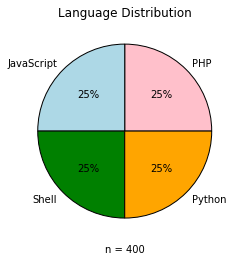

In [8]:
df.language.value_counts().plot.pie(
    colors = ['pink', 'lightblue', 'green', 'orange'], autopct = '%.0f%%')
plt.title("Language Distribution")
plt.ylabel("")
plt.xlabel('n = %d' % df.shape[0])

pd.concat(
    [df.language.value_counts(), df.language.value_counts(normalize = True)], axis = 1).set_axis(["n", "percent"], axis = 1, inplace = False)

**Note:** join all Readme and find high count of all words

In [9]:
pd.Series(" ".join(lemmas_df.lemmatized).split()).value_counts().head(10)

code      3207
img       3049
io        2972
file      2966
source    2849
use       2633
doc       2508
php       2387
e         2317
master    2280
dtype: int64

**Note:** words within each language

In [10]:
all_words = ' '.join(lemmas_df.lemmatized).split()

python_words = ' '.join(lemmas_df[lemmas_df.language == 'Python'].lemmatized).split()

javascript_words = ' '.join(lemmas_df[lemmas_df.language == 'JavaScript'].lemmatized).split()

php_words = ' '.join(lemmas_df[lemmas_df.language == 'PHP'].lemmatized).split()

shell_words = ' '.join(lemmas_df[lemmas_df.language == 'Shell'].lemmatized).split()

- Once we have a list of words, we can transform it into a pandas Series, which we can then use to show us how often each of the words occurs.

In [11]:
all_freq = pd.Series(all_words).value_counts()

python_words_freq = pd.Series(python_words).value_counts()

javascript_words_freq = pd.Series(javascript_words).value_counts()

php_words_freq = pd.Series(php_words).value_counts()

shell_words_freq = pd.Series(shell_words).value_counts()

### Term Frequency

Generally, when you hear 'Term Frequency', it is referring to the number of documents in which a word appears. When we move on to computing TF-IDF, this basic definition of Term Frequency applies.

However, term frequency can be calculated in a number of ways, all of which reflect how frequently a word appears in a document.

Raw Count: This is simply the count of the number of occurances of each word.
Frequency: The number of times each word appears divided by the total number of words.
Augmented Frequency: The frequency of each word divided by the maximum frequency. This can help prevent bias towards larger documents.

In [12]:
raw_count = (
    pd.concat([all_freq, python_words_freq, javascript_words_freq, php_words_freq, shell_words_freq], axis=1, sort=True)
    .rename(columns={0: "All", 1: "Python", 2: "JavaScript", 3: "PHP", 4: "Shell"})
    .fillna(0)
    .apply(lambda col: col.astype(int))
)

In [13]:
raw_count.T

,aa,aaa,aaaaaaaaaaaaaaaaaaaa,aaaaaaaaaaaaaaaaaaaaa,aaaaaaaaaac,aaaaaaaaaai,aaaaaaaad,aaaaaaaaecm,aaaaaaaaerc,aaaaaaaaex,...,zybuluo,zyclotrop,zyedidia,zynga,zypper,zyszys,zythum,zyusth,zzxadi,zzz
All,29,5,4,2,1,1,1,1,1,1,...,1,4,1,3,1,3,1,1,2,2
Python,7,0,4,2,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0
JavaScript,16,1,0,0,1,1,1,1,1,1,...,1,4,0,0,1,3,1,1,0,0
PHP,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0
Shell,0,4,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,2


**Task** Find record that has &#9

In [14]:
raw_count.sort_values(by="All").tail(10)

,All,Python,JavaScript,PHP,Shell
master,2280,1194,562,246,278
e,2317,399,1380,157,381
php,2387,22,812,1503,50
doc,2508,611,641,227,1029
use,2633,550,716,503,864
source,2849,287,2218,89,255
file,2966,731,566,326,1343
io,2972,588,1689,331,364
img,3049,645,1768,353,283
code,3207,679,1907,356,265


- Most common words overall?
- Most common Python, JavaScript, PHP, Shell words?
- Any words that uniquely Python, JavaScript, PHP, Shell words?

Text(0.5, 1.0, '10 most common words')

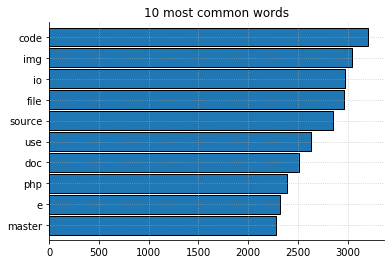

In [15]:
raw_count.sort_values(by='All')['All'].tail(10).plot.barh(width=.9)
plt.title('10 most common words')

Text(0.5, 1.0, '10 most common Python words')

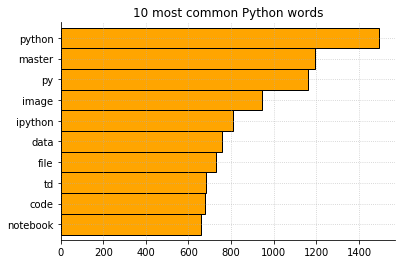

In [16]:
raw_count.sort_values(by='Python').Python.tail(10).plot.barh(width=1, color='Orange')
plt.title('10 most common Python words')

Text(0.5, 1.0, 'What are the most common JavaScript words')

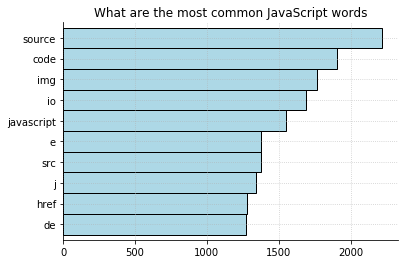

In [17]:
raw_count.sort_values(by='JavaScript').JavaScript.tail(10).plot.barh(width=1, color='lightblue')
plt.title('What are the most common JavaScript words')

Text(0.5, 1.0, 'What are the most common PHP words')

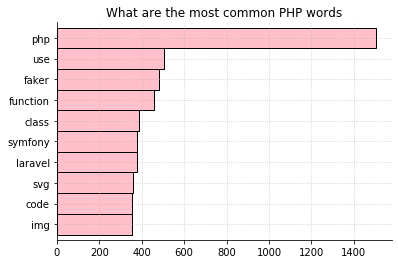

In [18]:
raw_count.sort_values(by='PHP').PHP.tail(10).plot.barh(width=1, color='pink')
plt.title('What are the most common PHP words')

Text(0.5, 1.0, 'What are the most common Shell words')

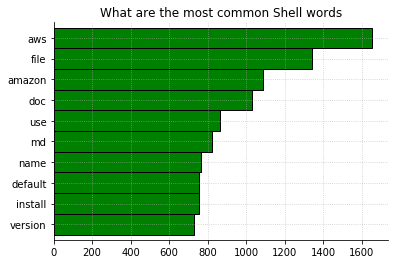

In [19]:
raw_count.sort_values(by='Shell').Shell.tail(10).plot.barh(width=1, color='green')
plt.title('What are the most common Shell words')

In [20]:
raw_count.head()

,All,Python,JavaScript,PHP,Shell
aa,29,7,16,6,0
aaa,5,0,1,0,4
aaaaaaaaaaaaaaaaaaaa,4,4,0,0,0
aaaaaaaaaaaaaaaaaaaaa,2,2,0,0,0
aaaaaaaaaac,1,0,1,0,0


In [58]:
tf_df = raw_count[['All']];
tf_df = tf_df.rename(columns={'All': 'raw_count'})
tf_df = tf_df.assign(frequency = lambda lemmas_df: lemmas_df.raw_count / lemmas_df.raw_count.sum())
tf_df = tf_df.assign(augmented_frequency = lambda lemmas_df: lemmas_df.frequency / lemmas_df.frequency.max())
tf_df.frequency.max()

tf_df.sample()


,raw_count,frequency,augmented_frequency
poisontap,4,0.000007,0.001247


### Ngrams

- Bigrams and visualizations of most frequent for all, Python, JavaScript, PHP, and Shell languages.

Text(0.5, 1.0, 'Bigrams for All Words')

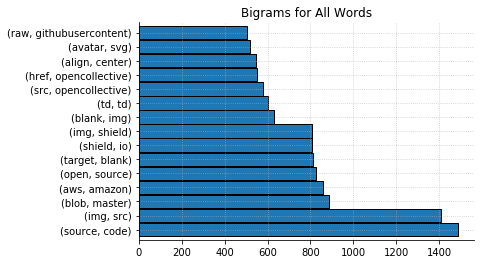

In [22]:
pd.Series(nltk.bigrams(all_words)).value_counts().head(15).plot.barh(width=.95).set_title('Bigrams for All Words')

Text(0.5, 1.0, 'Bigrams for Python Words')

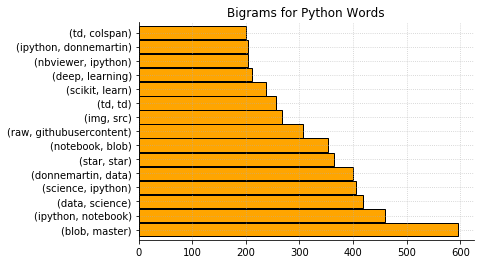

In [23]:
pd.Series(nltk.bigrams(python_words)).value_counts().head(15).plot.barh(width=.95, color='orange').set_title('Bigrams for Python Words')

Text(0.5, 1.0, 'Bigrams for JavaScript Words')

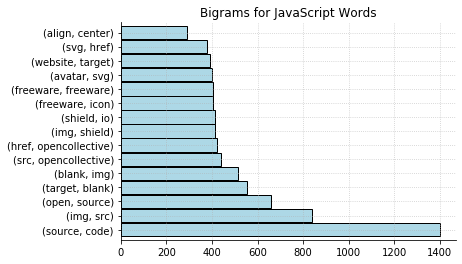

In [24]:
pd.Series(nltk.bigrams(javascript_words)).value_counts().head(15).plot.barh(width=.95, color='lightblue').set_title('Bigrams for JavaScript Words')

Text(0.5, 1.0, 'Bigrams for PHP Words')

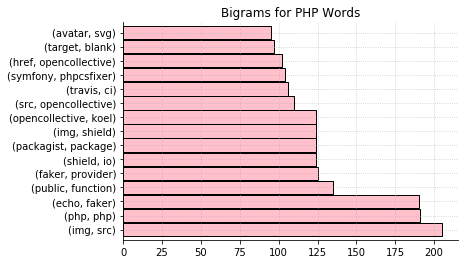

In [25]:
pd.Series(nltk.bigrams(php_words)).value_counts().head(15).plot.barh(width=.95, color='pink').set_title('Bigrams for PHP Words')

Text(0.5, 1.0, 'Bigrams for Shell Words')

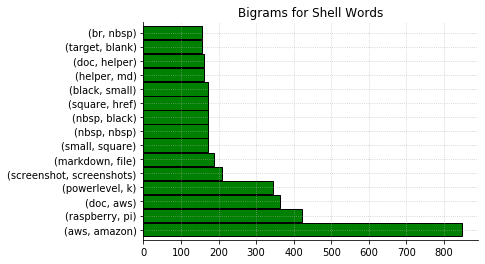

In [26]:
pd.Series(nltk.bigrams(shell_words)).value_counts().head(15).plot.barh(width=.95, color='green').set_title('Bigrams for Shell Words')

- Trigrams and visualizations of most frequent for all, Python, JavaScript, PHP, and Shell languages.

Text(0.5, 1.0, 'Trigrams for All Words')

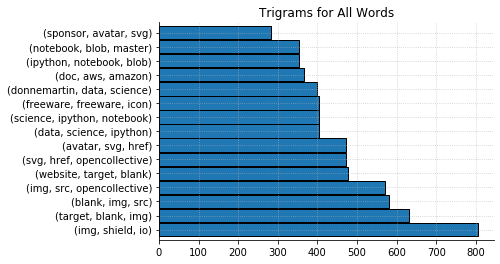

In [27]:
pd.Series(nltk.ngrams(all_words, 3)).value_counts().head(15).plot.barh(width=.95).set_title('Trigrams for All Words')

Text(0.5, 1.0, 'Trigrams for Python Words')

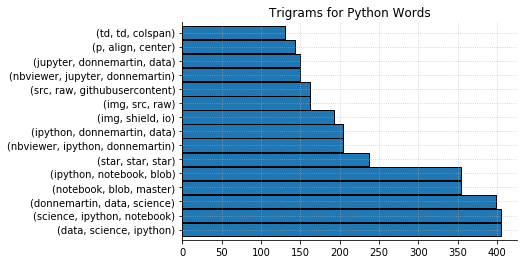

In [28]:
pd.Series(nltk.ngrams(python_words, 3)).value_counts().head(15).plot.barh(width=.95).set_title('Trigrams for Python Words')

Text(0.5, 1.0, 'Trigrams for JavaScript Words')

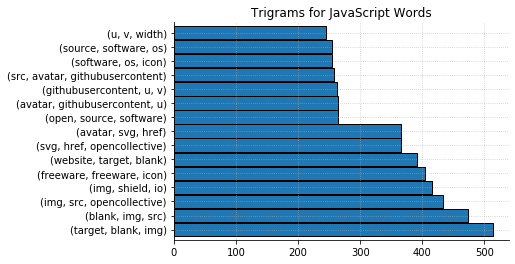

In [29]:
pd.Series(nltk.ngrams(javascript_words, 3)).value_counts().head(15).plot.barh(width=.95).set_title('Trigrams for JavaScript Words')

Text(0.5, 1.0, 'Trigrams for PHP Words')

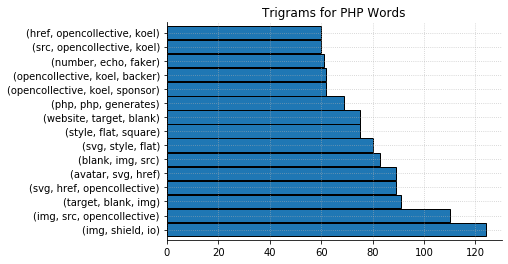

In [30]:
pd.Series(nltk.ngrams(php_words, 3)).value_counts().head(15).plot.barh(width=.95).set_title('Trigrams for PHP Words')

Text(0.5, 1.0, 'Trigrams for Shell Words')

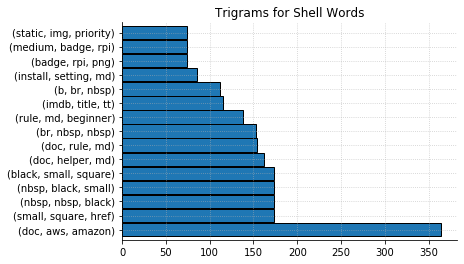

In [31]:
pd.Series(nltk.ngrams(shell_words, 3)).value_counts().head(15).plot.barh(width=.95).set_title('Trigrams for Shell Words')

### Document Length

In [32]:
lemmas_df["length"] = lemmas_df.lemmatized.apply(len)
lemmas_df.drop(index = lemmas_df[lemmas_df.length > 140000].index, inplace = True)

Text(0.5, 1.0, 'Document Length')

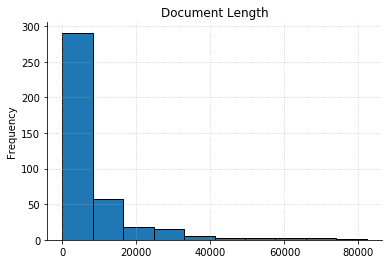

In [33]:
lemmas_df.length.plot.hist().set_title('Document Length')

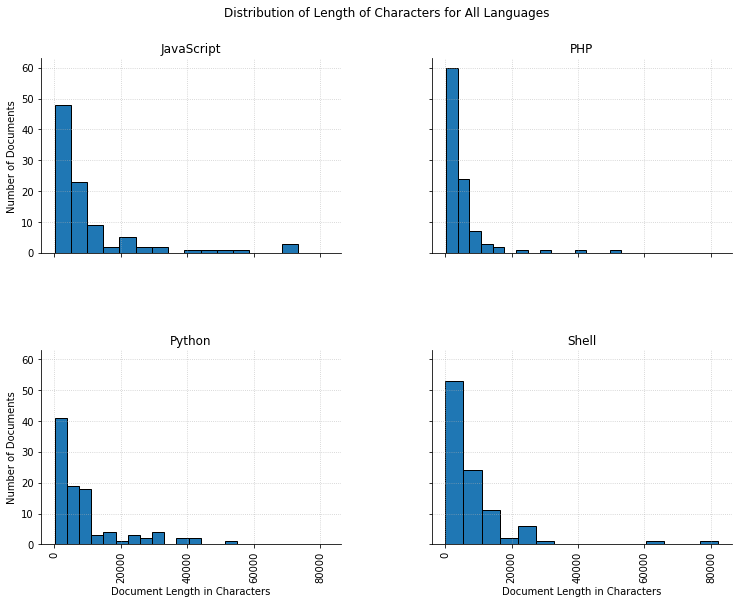

In [34]:
ar = lemmas_df.hist("length", by="language", sharex=True, sharey = True, layout=(2, 2), bins=15, figsize=(12, 9))
plt.suptitle('Distribution of Length of Characters for All Languages')

for ax in ar.flatten():
    ax.set_xlabel('Document Length in Characters')
    ax.set_ylabel('Number of Documents')
    ax.set

Text(0.5, 0, 'Length in Characters')

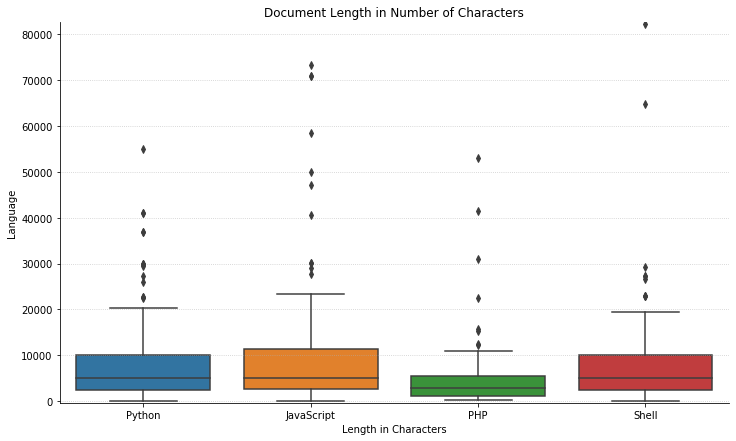

In [38]:
fig = plt.figure(figsize=(12, 7))

ax = sns.boxplot(data=lemmas_df, y="length", x="language")
ax.set_title('Document Length in Number of Characters')
ax.set_ylabel('Language')
ax.margins(.005) 
ax.set_xlabel('Length in Characters')

### Number of Words

In [39]:
lemmas_df["n_words"] = lemmas_df.lemmatized.str.count(r"\w+")

In [40]:
lemmas_df.groupby("language").n_words.describe()

,count,mean,std,min,25%,50%,75%,max
language,,,,,,,,
JavaScript,98.0,1609.755102,2280.916944,5.0,413.75,739.0,1634.50,11025.0
PHP,100.0,678.190000,1082.507832,31.0,153.25,387.5,747.75,7295.0
Python,100.0,1329.970000,1586.605763,3.0,335.75,727.0,1555.50,8570.0
Shell,99.0,1254.050505,1792.178963,1.0,334.00,756.0,1434.00,13114.0


Text(0.5, 1.0, 'Document Length in Number of Words')

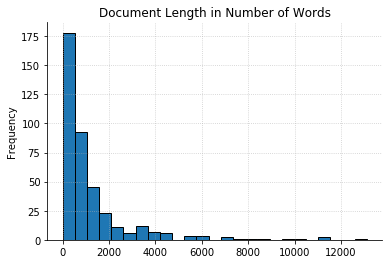

In [62]:
lemmas_df.n_words.plot.hist(bins = 25).set_title('Document Length in Number of Words')

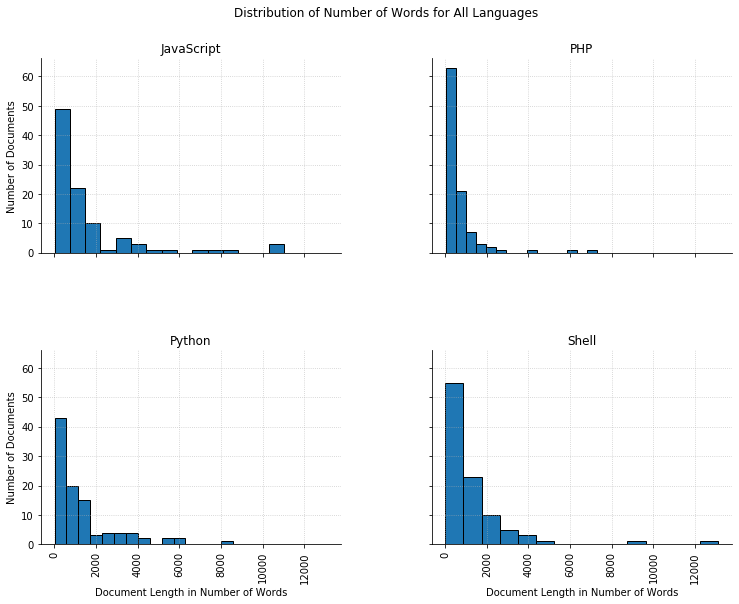

In [42]:
ar = lemmas_df.hist("n_words", by="language", sharex=True, sharey = True, layout=(2, 2), bins=15, figsize=(12, 9))
plt.suptitle("Distribution of Number of Words for All Languages")

for ax in ar.flatten():
    ax.set_xlabel('Document Length in Number of Words')
    ax.set_ylabel('Number of Documents')

### Word Cloud

- WordCloud with all words

(-0.5, 1499.5, 999.5, -0.5)

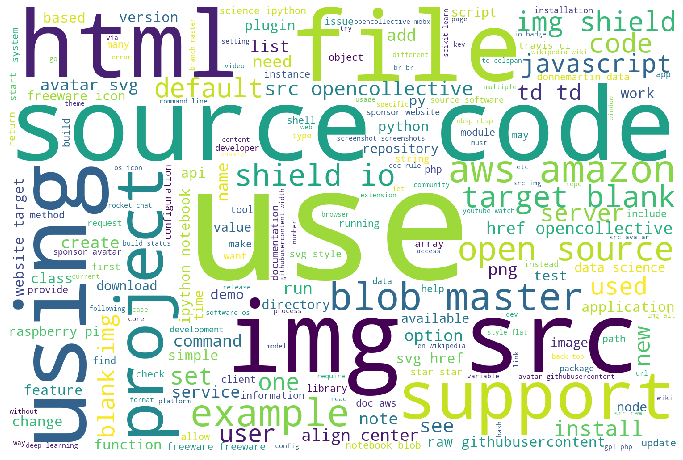

In [43]:
corpus = ' '.join(all_words)

plt.figure(figsize=(12,12))
img = WordCloud(background_color="white", height=1000, width=1500, random_state=123).generate(corpus)
plt.imshow(img)
plt.axis("off")

- WordCloud with all words by languages

In [44]:
python_corpus = ' '.join(python_words)
javascript_corpus = ' '.join(javascript_words)
php_corpus = ' '.join(php_words)
shell_corpus = ' '.join(shell_words)

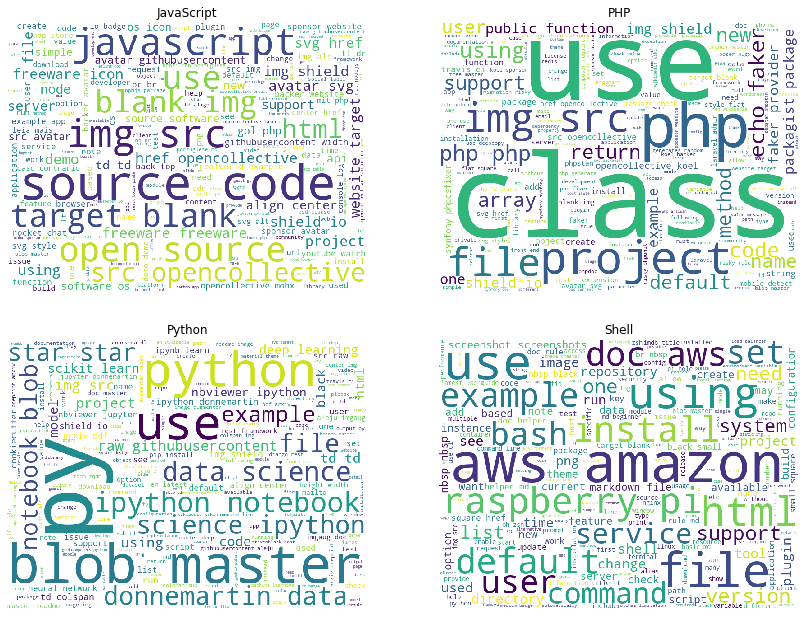

In [45]:
python_cloud = WordCloud(background_color="white", height=600, width=800).generate(
    " ".join(python_words)
)
javascript_cloud = WordCloud(background_color="white", height=600, width=800).generate(
    " ".join(javascript_words)
)
php_cloud = WordCloud(background_color="white", height=600, width=800).generate(
    " ".join(php_words)
)
shell_cloud = WordCloud(background_color="white", height=600, width=800).generate(
    " ".join(shell_words)
)

plt.figure(figsize=(10, 8))
axs = [
    plt.axes([0, 0, 0.5, 0.5]),
    plt.axes([0, 0.55, 0.5, .5]),
    plt.axes([0.6, 0.55, 0.5, 0.5]),
    plt.axes([0.6, 0, 0.5, 0.5]),
]

axs[0].imshow(python_cloud)
axs[1].imshow(javascript_cloud)
axs[2].imshow(php_cloud)
axs[3].imshow(shell_cloud)

axs[0].set_title("Python")
axs[1].set_title("JavaScript")
axs[2].set_title("PHP")
axs[3].set_title("Shell")

for ax in axs:
    ax.axis("off")    

### Word Cloud with Bigrams

Text(0.5, 1.0, 'Bigrams Word Cloud with All Words')

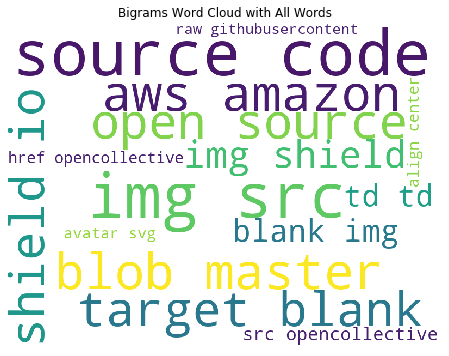

In [46]:
all_bigrams = pd.Series(nltk.bigrams(all_words)).value_counts().head(15)

all_data = {p1 + " " + p2: v for (p1, p2), v in all_bigrams.to_dict().items()}

img = WordCloud(background_color="white", height=600, width=800).generate_from_frequencies(all_data)
plt.figure(figsize=(9, 6))
plt.imshow(img)
plt.axis("off")
plt.title('Bigrams Word Cloud with All Words')

Text(0.5, 1.0, 'Bigrams Word Cloud with Python Words')

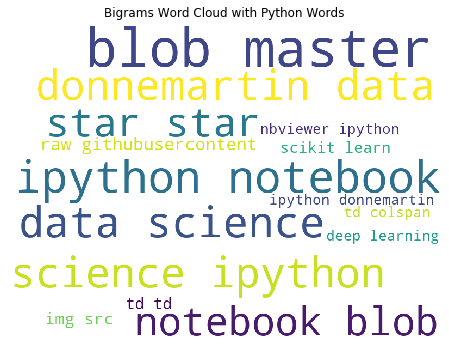

In [47]:
python_bigrams = pd.Series(nltk.bigrams(python_words)).value_counts().head(15)

python_data = {p1 + " " + p2: v for (p1, p2), v in python_bigrams.to_dict().items()}

img = WordCloud(background_color="white", height=600, width=800).generate_from_frequencies(python_data)
plt.figure(figsize=(9, 6))
plt.imshow(img)
plt.axis("off")
plt.title('Bigrams Word Cloud with Python Words')

Text(0.5, 1.0, 'Bigrams Word Cloud with JavaScript Words')

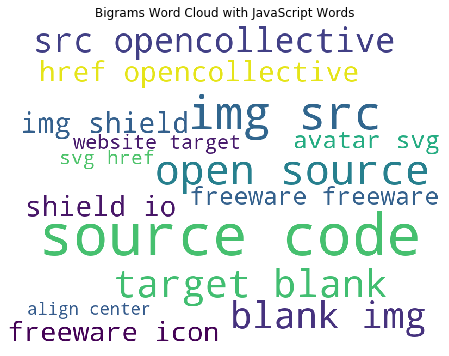

In [48]:
javascript_bigrams = pd.Series(nltk.bigrams(javascript_words)).value_counts().head(15)

javascript_data = {p1 + " " + p2: v for (p1, p2), v in javascript_bigrams.to_dict().items()}

img = WordCloud(background_color="white", height=600, width=800).generate_from_frequencies(javascript_data)
plt.figure(figsize=(9, 6))
plt.imshow(img)
plt.axis("off")
plt.title('Bigrams Word Cloud with JavaScript Words')

Text(0.5, 1.0, 'Bigrams Word Cloud with PHP Words')

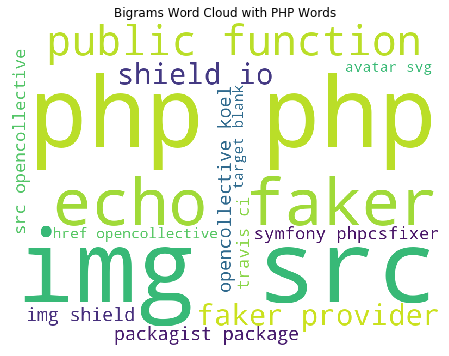

In [49]:
php_bigrams = pd.Series(nltk.bigrams(php_words)).value_counts().head(15)

php_data = {p1 + " " + p2: v for (p1, p2), v in php_bigrams.to_dict().items()}

img = WordCloud(background_color="white", height=600, width=800).generate_from_frequencies(php_data)
plt.figure(figsize=(9, 6))
plt.imshow(img)
plt.axis("off")
plt.title('Bigrams Word Cloud with PHP Words')

Text(0.5, 1.0, 'Bigrams Word Cloud with Shell Words')

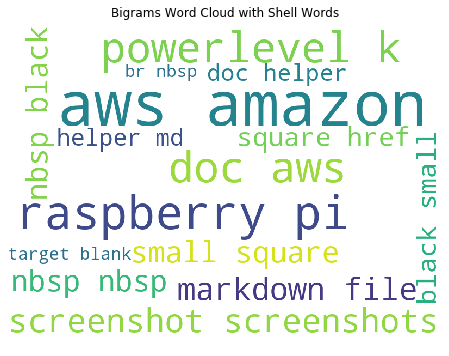

In [50]:
shell_bigrams = pd.Series(nltk.bigrams(shell_words)).value_counts().head(15)

shell_data = {p1 + " " + p2: v for (p1, p2), v in shell_bigrams.to_dict().items()}

img = WordCloud(background_color="white", height=600, width=800).generate_from_frequencies(shell_data)
plt.figure(figsize=(9, 6))
plt.imshow(img)
plt.axis("off")
plt.title('Bigrams Word Cloud with Shell Words')

### Word Cloud with Trigrams

Text(0.5, 1.0, 'Trigrams with All Words')

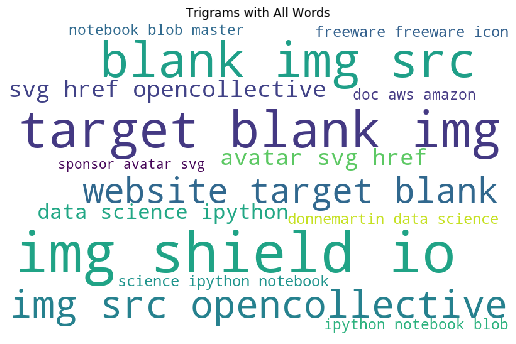

In [51]:
all_trigrams = pd.Series(nltk.ngrams(all_words, 3)).value_counts().head(15)

data = {p1 + " " + p2 + " " + p3: v for (p1, p2, p3), v in all_trigrams.to_dict().items()}

frequencies = data

img = WordCloud(background_color="white", height=500, width=800).generate_from_frequencies(data)
plt.figure(figsize=(9, 6))
plt.imshow(img)
plt.axis("off")
plt.title('Trigrams with All Words')

Text(0.5, 1.0, 'Trigrams with Python Words')

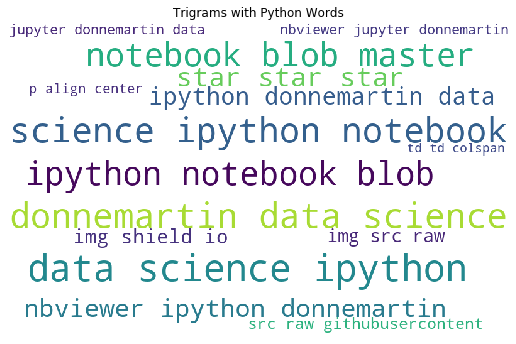

In [52]:
python_trigrams = pd.Series(nltk.ngrams(python_words, 3)).value_counts().head(15)

data = {p1 + " " + p2 + " " + p3: v for (p1, p2, p3), v in python_trigrams.to_dict().items()}

frequencies = data

img = WordCloud(background_color="white", height=500, width=800).generate_from_frequencies(data)
plt.figure(figsize=(9, 6))
plt.imshow(img)
plt.axis("off")
plt.title('Trigrams with Python Words')

Text(0.5, 1.0, 'Trigrams with JavaScript Words')

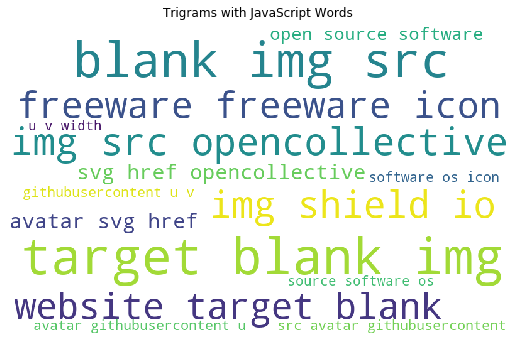

In [53]:
javascript_trigrams = pd.Series(nltk.ngrams(javascript_words, 3)).value_counts().head(15)

data = {p1 + " " + p2 + " " + p3: v for (p1, p2, p3), v in javascript_trigrams.to_dict().items()}

frequencies = data

img = WordCloud(background_color="white", height=500, width=800).generate_from_frequencies(data)
plt.figure(figsize=(9, 6))
plt.imshow(img)
plt.axis("off")
plt.title('Trigrams with JavaScript Words')

Text(0.5, 1.0, 'Trigrams with PHP Words')

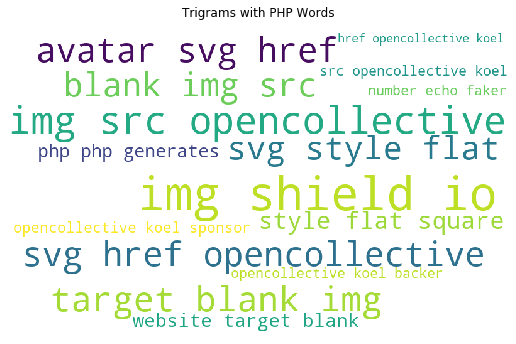

In [54]:
php_trigrams = pd.Series(nltk.ngrams(php_words, 3)).value_counts().head(15)

data = {p1 + " " + p2 + " " + p3: v for (p1, p2, p3), v in php_trigrams.to_dict().items()}

frequencies = data

img = WordCloud(background_color="white", height=500, width=800).generate_from_frequencies(data)
plt.figure(figsize=(9, 6))
plt.imshow(img)
plt.axis("off")
plt.title('Trigrams with PHP Words')

Text(0.5, 1.0, 'Trigrams with Shell Words')

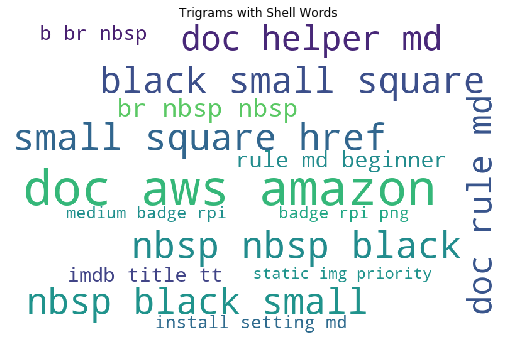

In [55]:
shell_trigrams = pd.Series(nltk.ngrams(shell_words, 3)).value_counts().head(15)

data = {p1 + " " + p2 + " " + p3: v for (p1, p2, p3), v in shell_trigrams.to_dict().items()}

frequencies = data

img = WordCloud(background_color="white", height=500, width=800).generate_from_frequencies(data)
plt.figure(figsize=(9, 6))
plt.imshow(img)
plt.axis("off")
plt.title('Trigrams with Shell Words')